In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading the data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# hyperparameters
image_size = 28
image_shape = (image_size, image_size)
image_shape_flat = image_size * image_size
num_classes = 10

In [4]:
def plot_images(images, true_class, pred_class=None):
    assert len(images) == len(true_class) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(image_shape), cmap='binary')

        # Show true and predicted classes.
        if pred_class is None:
            xlabel = "True: {0}".format(true_class[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(true_class[i], pred_class[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
data.train.cls = np.argmax(data.train.labels, axis=1)
data.test.cls = np.argmax(data.test.labels, axis=1)

In [6]:
data.train.cls[:3]

array([7, 3, 4])

In [7]:
data.test.cls[:3]

array([7, 2, 1])

In [8]:
data.test.labels[:3]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

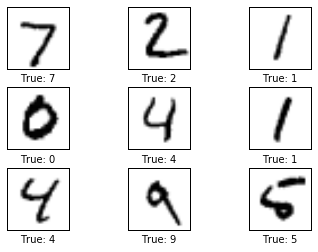

In [9]:
# Plot some images
images = data.test.images[:9]
true_class = data.test.cls[:9]
plot_images(images, true_class)

In [10]:
# Start defining our placeholders
X = tf.placeholder(tf.float32, [None, image_shape_flat])
y = tf.placeholder(tf.float64, [None, num_classes])
y_class = tf.placeholder(tf.int64, [None])

In [11]:
W = tf.Variable(tf.zeros([image_shape_flat, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

In [12]:
output = tf.matmul(X, W) + b
y_pred = tf.nn.softmax(output)
y_pred_class = tf.argmax(y_pred, dimension=1)

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(learning_rate=1e-3).minimize(cost)

In [14]:
correct_class = tf.equal(y_pred_class, y_class)
accuracy = tf.reduce_mean(tf.cast(correct_class, tf.float32))

In [15]:
# Initialize our session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
batch_size = 100
no_of_optimization = 0
def optimize(n_epochs=1, log_freq=20):
    global no_of_optimization
    print('Optimizing...')
    for i in range(n_epochs):
        no_of_optimization += 1
        batch_X, batch_y = data.train.next_batch(batch_size)
        feed_dict_train = {X: batch_X, y:batch_y}
        _,c = sess.run([optimizer,cost], feed_dict=feed_dict_train)
        if i % log_freq == 0:
            print('{}. Cost = {:.4f}'.format(i+1, c))
    print('Optimized', no_of_optimization, 'times!')

In [17]:
feed_dict_test = {X:data.test.images, 
                  y:data.test.labels,
                  y_class:data.test.cls}

In [18]:
def print_accuracy():
    acc = sess.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy = {:.1%}'.format(acc))

In [19]:
def plot_example_errors():
    print('Incorrect Classification:')
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, pred_class = sess.run([correct_class, y_pred_class],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    pred_class = pred_class[incorrect]

    # Get the true classes for those images.
    true_class = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                true_class=true_class[0:9],
                pred_class=pred_class[0:9])

In [20]:
def plot_correct_class():
    print('Correct Classification:')
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, pred_class = sess.run([correct_class, y_pred_class],
                                    feed_dict=feed_dict_test)
    
    # Get the images from the test-set that have been
    # correctly classified.
    images = data.test.images[correct]
    
    # Get the predicted classes for those images.
    pred_class = pred_class[correct]

    # Get the true classes for those images.
    true_class = data.test.cls[correct]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                true_class=true_class[0:9],
                pred_class=pred_class[0:9])

In [21]:
def plot_weights():
    print('Weights:')
    # Get the values for the weights from the TensorFlow variable.
    w = sess.run(W)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(image_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [22]:
data.train.images.dtype

dtype('float32')

In [23]:
data.train.labels.dtype

dtype('float64')

Optimizing...
1. Cost = 2.3026
Optimized 1 times!
Accuracy = 40.9%
Incorrect Classification:
Weights:


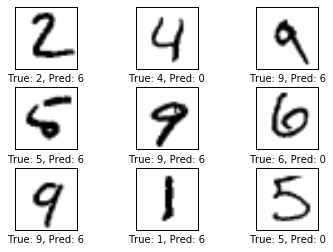

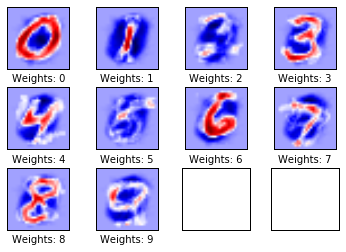

In [24]:
optimize()
print_accuracy()
plot_example_errors()
plot_weights()

Optimizing...
1. Cost = 2.2984
Optimized 10 times!
Accuracy = 50.5%
Incorrect Classification:
Weights:


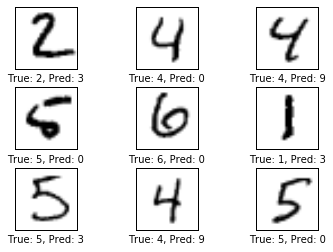

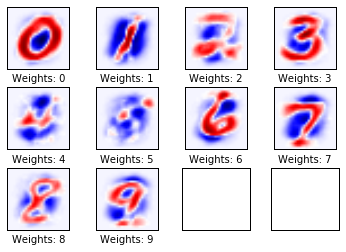

In [25]:
optimize(9)
print_accuracy()
plot_example_errors()
plot_weights()

Optimizing...
1. Cost = 2.2592
11. Cost = 2.2360
21. Cost = 2.1905
31. Cost = 2.1685
41. Cost = 2.1455
51. Cost = 2.0813
61. Cost = 2.1146
71. Cost = 2.0909
81. Cost = 2.0697
Optimized 100 times!
Accuracy = 70.6%
Incorrect Classification:
Weights:


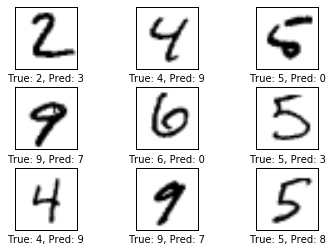

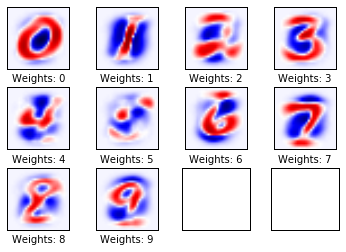

In [26]:
optimize(90,10)
print_accuracy()
plot_example_errors()
plot_weights()

Optimizing...
1. Cost = 2.0381
101. Cost = 1.8516
201. Cost = 1.7426
301. Cost = 1.6965
401. Cost = 1.4929
501. Cost = 1.4473
601. Cost = 1.3693
701. Cost = 1.3752
801. Cost = 1.3224
Optimized 1000 times!
Accuracy = 81.7%
Incorrect Classification:
Weights:


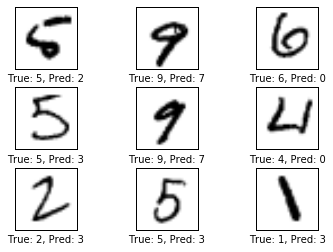

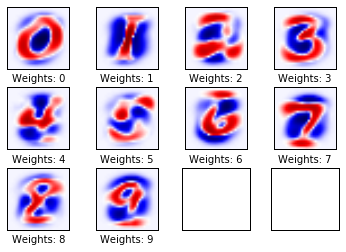

In [27]:
optimize(900, 100)
print_accuracy()
plot_example_errors()
plot_weights()

Optimizing...
1. Cost = 1.3183
1001. Cost = 0.9748
2001. Cost = 0.8600
3001. Cost = 0.7763
4001. Cost = 0.7449
5001. Cost = 0.7034
6001. Cost = 0.6950
7001. Cost = 0.6570
8001. Cost = 0.7074
Optimized 10000 times!
Accuracy = 87.4%
Incorrect Classification:
Weights:


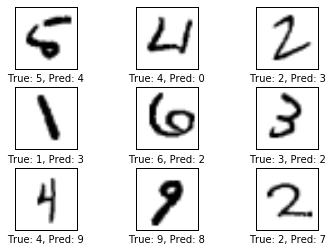

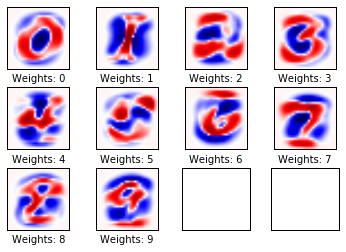

In [28]:
optimize(9000, 1000)
print_accuracy()
plot_example_errors()
plot_weights()

In [29]:
sess.close()